In [1]:
from pathlib import Path
from dynamic_fusion.utils.dataset import CocoTestDataset
from dynamic_fusion.utils.evaluation import get_metrics
from matplotlib import pyplot as plt


dataset_path = Path('..', 'data', 'interim', 'coco', 'train', '2subbins')


metrics_temporal_scale = []
dataset = CocoTestDataset(dataset_path, (1, 4), threshold=1.35)

/home/davton/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
from dynamic_fusion.network_trainer.configuration import TrainerConfiguration
from dynamic_fusion.network_trainer.network_loader import NetworkLoader


checkpoints = [Path("../runs/0323-new-dataset/00_st-un_st-interp_st-up_uncertainty-lpips/subrun_00")]
checkpoint_dir = checkpoints[0]

config_path = checkpoint_dir / "config.json"
with config_path.open("r", encoding="utf8") as f:
    json_config = f.read()
# Parse the JSON string back into a Configuration instance
config = TrainerConfiguration.parse_raw(json_config)

config.network_loader.decoding_checkpoint_path = checkpoint_dir / "latest_checkpoint.pt"
config.network_loader.encoding_checkpoint_path = checkpoint_dir / "latest_checkpoint.pt"

device = torch.device("cuda")

encoder, decoder = NetworkLoader(config.network_loader, config.shared).run()
encoder = encoder.to(device)
decoder = decoder.to(device)

In [3]:
from dynamic_fusion.utils.dataset import collate_test_items
from dynamic_fusion.utils.evaluation import get_reconstructions_and_gt

i=2
sample = dataset[i]
batch = collate_test_items([sample])
scale = 1.5
recon, gt, _, _ = get_reconstructions_and_gt(
    batch,
    encoder,
    decoder,
    config.shared,
    device,
    scale=1,
    Ts_to_evaluate=100,
    taus_to_evaluate=1,
)


In [4]:
import numpy as np

PATCH_SIZE = 16

height, width = recon.shape[2], recon.shape[3]
crop_height = height % PATCH_SIZE
crop_width = width % PATCH_SIZE

# Calculate the starting indices for cropping
start_crop_height = crop_height // 2
start_crop_width = crop_width // 2

# Crop to make the height and width divisible by PATCH_SIZE
cropped_recon = recon[:, :, start_crop_height:height - (crop_height - start_crop_height), start_crop_width:width - (crop_width - start_crop_width)]
cropped_gt = gt[:, start_crop_height:height - (crop_height - start_crop_height), start_crop_width:width - (crop_width - start_crop_width)]


In [5]:
import einops

patched_recon = einops.rearrange(cropped_recon, "B C (X PATCH_X) (Y PATCH_Y) -> (B X Y) C PATCH_X PATCH_Y", PATCH_X = PATCH_SIZE, PATCH_Y = PATCH_SIZE)
patched_gt = einops.rearrange(cropped_gt, "B (X PATCH_X) (Y PATCH_Y) -> (B X Y) PATCH_X PATCH_Y", PATCH_X = PATCH_SIZE, PATCH_Y = PATCH_SIZE)

In [6]:
correlations = []
for recon_patch, gt_patch in zip(patched_recon, patched_gt):
    correlations.append(np.corrcoef(recon_patch[0].flatten(), gt_patch.flatten())[0,1])
correlations = np.array(correlations)

median_stds = np.median(np.exp(patched_recon[:,1]), axis=(1,2))
mean_stds = np.mean(np.exp(patched_recon[:,1]), axis=(1,2))

In [7]:
from dynamic_fusion.utils.loss import LPIPS

LPIPS_BATCH = 200
with torch.no_grad():
    lpips = LPIPS(spatial=False).to(device)
    lpips_values = []
    for i in range(0, len(patched_recon), LPIPS_BATCH):
        lpips_values.append(lpips(torch.tensor(patched_recon[i:i+LPIPS_BATCH, 0:1]).cuda(), torch.tensor(patched_gt[i:i+LPIPS_BATCH, None]).cuda()).detach().cpu().numpy().flatten())



Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/davton/miniconda3/envs/thesis/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/davton/miniconda3/envs/thesis/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/davton/.local/lib/python3.9/site-packages/lpips/weights/v0.1/vgg.pth


In [8]:
lpips_values = np.concatenate(lpips_values, axis=0)

In [12]:
print(np.corrcoef(correlations, median_stds))
print(np.corrcoef(correlations, mean_stds))

[[ 1.         -0.02474577]
 [-0.02474577  1.        ]]
[[1.         0.16138366]
 [0.16138366 1.        ]]


In [13]:
print(np.corrcoef(lpips_values, median_stds))
print(np.corrcoef(lpips_values, mean_stds))

[[1.        0.2533675]
 [0.2533675 1.       ]]
[[1.        0.0286376]
 [0.0286376 1.       ]]


In [19]:
print(np.corrcoef(median_stds, mean_stds))

[[1.         0.88518756]
 [0.88518756 1.        ]]


0.12436251
0.13695604


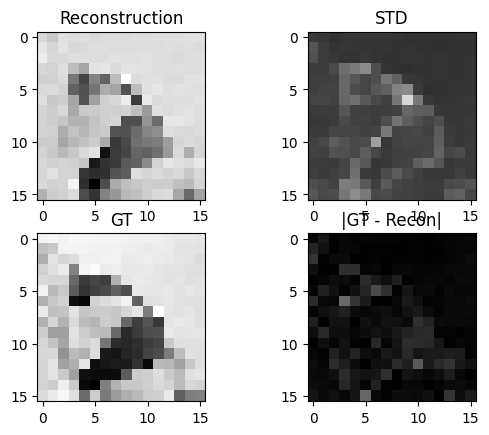

In [15]:
import numpy as np
from matplotlib import pyplot as plt

I = 300

fig, axs = plt.subplots(2,2)
axs[0,0].imshow(patched_recon[I,0], cmap='gray')
axs[0,0].set_title('Reconstruction')
axs[0,1].imshow(np.exp(patched_recon[I,1]), cmap='gray', vmin=0, vmax=0.5)
axs[0,1].set_title('STD')
axs[1,0].imshow(patched_gt[I], cmap='gray')
axs[1,0].set_title('GT')
axs[1,1].imshow(np.abs(patched_gt[I] - patched_recon[I,0]), cmap='gray', vmin=0, vmax=1)
axs[1,1].set_title('|GT - Recon|')

print(median_stds[I])
print(mean_stds[I])

plt.show()

In [36]:
import itertools


Xs = ['median', 'mean']
Ys = ['LPIPS', 'correlation']

for (X,Y) in itertools.product(Xs, Ys):
    print(X,Y)

median LPIPS
median correlation
mean LPIPS
mean correlation


/tmp/ipykernel_346867/3161205151.py:17: RuntimeWarning: Mean of empty slice.
  avg_x = [x[bins == i].mean() for i in range(1, len(bin_edges))]
/tmp/ipykernel_346867/3161205151.py:18: RuntimeWarning: Mean of empty slice.
  avg_y = [y[bins == i].mean() for i in range(1, len(bin_edges))]


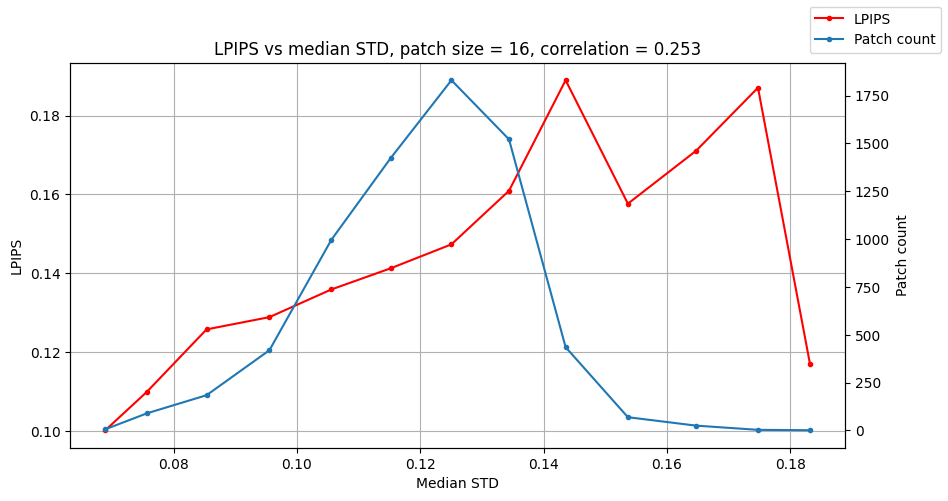

In [35]:
X = 'median'
Y = 'LPIPS'



# Define the bin edges
bin_edges = np.arange(0.05, 0.25, 0.01)  # Bins from 0 to 1, in steps of 0.05

fig, ax1 = plt.subplots(figsize=(10,5))

# Digitize x values
bins = np.digitize(median_stds, bin_edges)

x = mean_stds if X == 'mean' else median_stds
y = lpips_values if Y == 'LPIPS' else correlations

avg_x = [x[bins == i].mean() for i in range(1, len(bin_edges))]
avg_y = [y[bins == i].mean() for i in range(1, len(bin_edges))]
counts = [np.sum(bins == i) for i in range(1, len(bin_edges))]


# Plotting
ax1.plot(avg_x, avg_y, '.-r', label=Y)


ax1.set_title(f'LPIPS vs {X} STD, patch size = {PATCH_SIZE}, correlation = {np.corrcoef(x, y)[0,1]:.3f}')
ax1.set_xlabel('Mean STD' if X == 'mean' else 'Median STD')
ax1.set_ylabel('LPIPS' if Y == 'LPIPS' else 'Pearson correlation')
ax1.grid(True)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Patch count')  # we already handled the x-label with ax1
ax2.plot(avg_x,counts, '.-', label='Patch count')

fig.legend()

plt.show()

In [73]:
bins

array([10, 11, 11, ...,  8,  8,  8])

In [62]:
mean_stds.max()

0.21232794